In [1]:
import os
os. chdir("c:\\Users\\simon\\OneDrive\\Dokumente\\UNILU\\3 - HS24\\1 MA\\business-reports-nlp")

In [2]:
import pandas as pd

# Preparing the data

In [3]:
classification = pd.read_csv("data/fine-tuning v1/240101_classification_results.csv")
classification = classification.rename(columns={'240101_preds': 'classification'})

In [4]:
sample = pd.read_excel("data/sample.xlsx")
sample = sample.drop(['key', 'note'], axis=1)
sample = sample.rename(columns={'category': 'classification'})
sample2 = pd.read_excel("data/sample2.xlsx")
sample2 = sample2.drop(['Spalte1'], axis=1)
sample2 = sample2[pd.notna(sample2['classification'])]
sample2 = sample2.rename(columns={'year_x': 'year', 'file_name_x': 'file_name', 'file_path_x': 'file_path', 'source_x': 'source'})
sample3 = pd.read_excel("data/sample3-classified.xlsx")
sample3 = sample3.drop(['predictions', 'Spalte1'], axis=1)
sample3 = sample3.rename(columns={'year_x': 'year', 'file_name_x': 'file_name', 'file_path_x': 'file_path', 'source_x': 'source', 'corrected': 'classification'})

In [5]:
df = pd.concat([classification, sample, sample2, sample3], ignore_index=True)
df = df.drop(['index'], axis=1)

In [6]:
df['classification'] = df['classification'].replace("Interactions between Payment Players", "Interactions between Payments Players")
df['classification'] = df['classification'].replace("New category: Interactions between Payments Players", "Interactions between Payments Players")
df['classification'] = df['classification'].replace("New category: Sustainability", "Sustainability")
df['classification'] = df['classification'].replace("Sustainablity", "Sustainability")

In [7]:
import re

def clean_text_column(df, column_name):
    """
    Cleans the text entries in the specified column of a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the text column.
    column_name (str): The name of the column to be cleaned.
    
    Returns:
    pd.DataFrame: The DataFrame with cleaned text in the specified column.
    """
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_cleaned = df.copy()

    # Replace "- " with nothing
    df_cleaned.loc[:, column_name] = df_cleaned[column_name].str.replace("- ", "", regex=False)
    
    # Replace multiple spaces with a single space
    df_cleaned.loc[:, column_name] = df_cleaned[column_name].apply(lambda x: re.sub(' +', ' ', x))
    
    return df_cleaned

In [8]:
clean_text_column(df, 'content')
df = df.drop_duplicates(subset='content', keep='first')

In [32]:
sum(df['content'].duplicated())

0

In [33]:
df.isna().sum()

file_name         0
file_path         0
source            0
content           0
year              0
classification    0
dtype: int64

In [9]:
df.to_csv('data/final.csv', index=False)

In [11]:
def remove_illegal_characters(s):
    if isinstance(s, str):
        return ''.join([char for char in s if char.isprintable()])
    else:
        return s

# Apply the function to each string column
for col in df.select_dtypes(include=['object']):
    df[col] = df[col].apply(remove_illegal_characters)

df.to_excel('data/final.xlsx', index=False, engine='openpyxl')

# Visualisations

In [10]:
import matplotlib.pyplot as plt
plt.style.use("default")
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12

## classification frequency

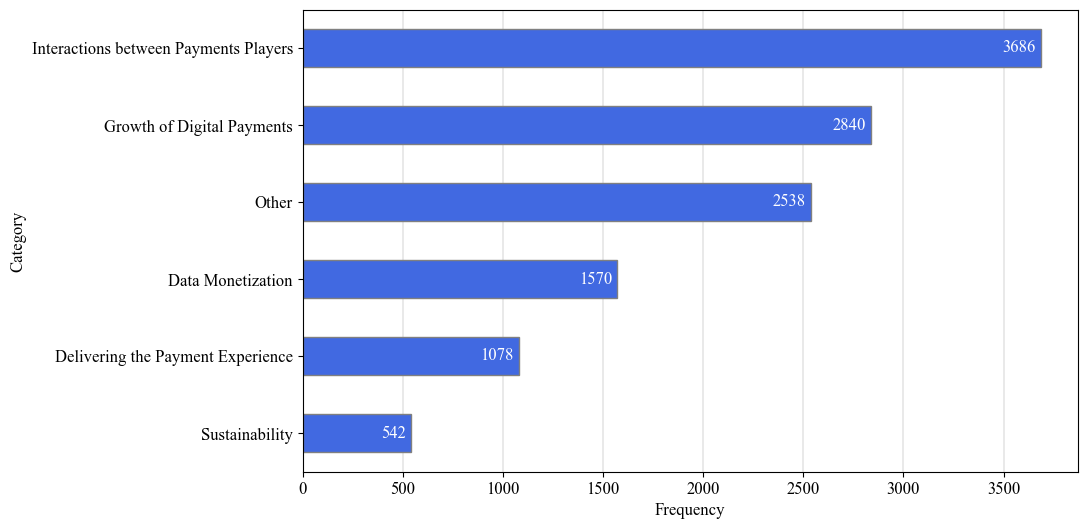

In [27]:
# count sources
classification_counts = df['classification'].value_counts().sort_values(ascending = False)
# plot sources
plt.figure(figsize=(10, 6))
ax = classification_counts.plot(kind='barh', color="royalblue", edgecolor='grey')
#plt.title('Value Counts in category_column')
plt.xlabel('Frequency')
plt.ylabel('Category')
plt.gca().invert_yaxis()
# Add grid
plt.gca().set_axisbelow(True)
plt.grid(True, which='both', axis='x', color='gray', linestyle='-', linewidth=0.25)
# Add value labels inside the bars
for p in ax.patches:
    label_x_position = p.get_width() - 25  # Adjust this value to position the label more to the left or right
    ax.text(label_x_position, p.get_y() + p.get_height() / 2, f'{int(p.get_width())}', 
            va='center', ha='right', color='white')
plt.savefig('figs/automated_content_analysis/classification_freq.png', dpi=1200, bbox_inches='tight')
plt.show()

In [19]:
classification_counts

,count
classification,
Interactions between Payments Players,3686
Growth of Digital Payments,2840
Other,2538
Data Monetization,1570
Delivering the Payment Experience,1078
Sustainability,542


## year frequency

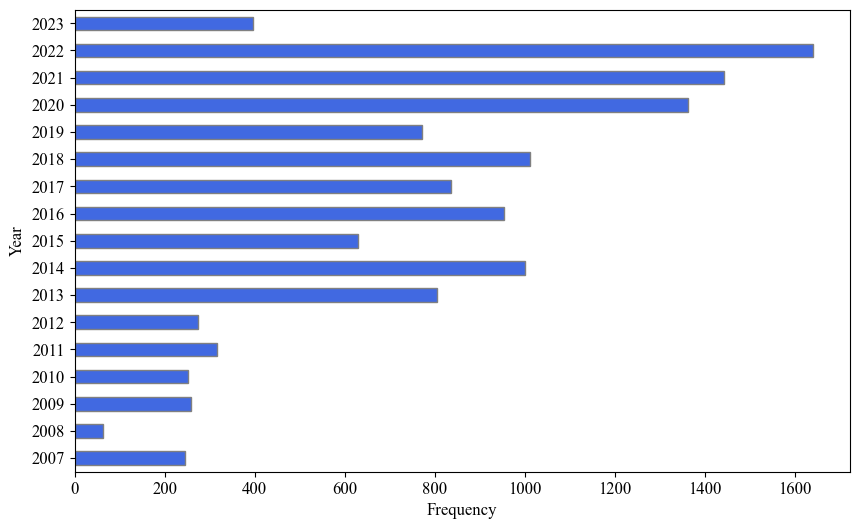

In [57]:
# count sources
year_counts = df['year'].value_counts().sort_index(ascending=False)
# plot sources
plt.figure(figsize=(10, 6))
year_counts.plot(kind='barh', color = "royalblue", edgecolor='grey')
#plt.title('Value Counts in category_column')
plt.xlabel('Frequency')
plt.ylabel('Year')
plt.gca().invert_yaxis()
plt.savefig('figs/automated_content_analysis/year_freq.png', dpi=1200)
plt.show()

## stories over time

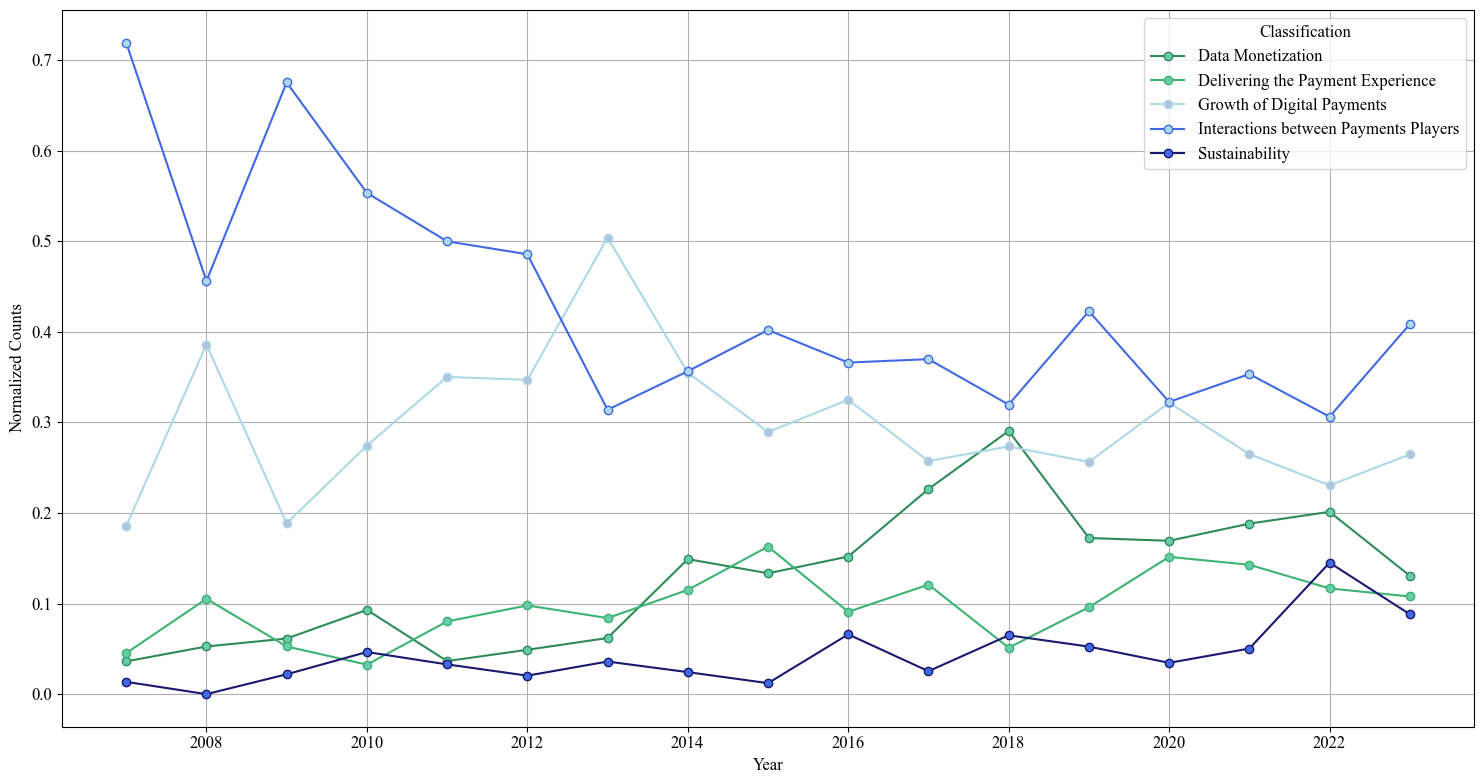

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

filtered_df = df[df['classification'] != 'Other']

# Group by 'year' and 'classification', then count occurrences
grouped = filtered_df.groupby(['year', 'classification']).size()

# Unstack to pivot the 'classification' categories into separate columns
#unstacked = grouped.unstack('classification', fill_value=0)

# Calculate the total counts per year
total_counts_per_year = filtered_df.groupby('year').size()

# Normalize the counts by dividing by the total counts per year
normalized = grouped.unstack('classification', fill_value=0).div(total_counts_per_year, axis=0)

# Colors
colors = ['seagreen', 'mediumseagreen', 'lightblue', 'royalblue', 'midnightblue']#[mcolors.to_hex(c) for c in mcolors.LinearSegmentedColormap.from_list("", ["darkblue", "lightblue"])([i/4 for i in range(5)])]
markercolors = ['mediumaquamarine', 'mediumaquamarine', 'lightsteelblue', 'lightblue', 'royalblue']#[mcolors.to_hex(c) for c in mcolors.LinearSegmentedColormap.from_list("", ["darkcyan", "lightcyan"])([i/4 for i in range(5)])]

# Plotting
plt.figure(figsize=(15, 8))
for (columnName, columnData) in normalized.items():
    plt.plot(columnData.index, columnData.values, marker='o',
             linestyle='-', color=colors.pop(0), markerfacecolor=markercolors.pop(0),
             label=columnName)

plt.legend(title="Classification", loc="best")
plt.xlabel('Year')
plt.ylabel('Normalized Counts')
#plt.title('Normalized Counts of Classifications Per Year')
plt.grid(True)
plt.tight_layout()
plt.savefig('figs/automated_content_analysis/stories_over_time.png', dpi=1200)
plt.show()